# Query para Churn Semestral já Retirando os Anos de 2004 e 2005 (anomalias)

✅ Sucesso! Os dados foram carregados em 'df_churn_semestral'.
------------------------------
  periodo_semestral  clientes_inicio_semestre  total_churn_no_semestre  \
0           2006-S1                       782                       82   
1           2006-S2                       982                      104   
2           2007-S1                      1125                      128   
3           2007-S2                      1252                      107   
4           2008-S1                      1470                      138   
5           2008-S2                      1654                      193   
6           2009-S1                      1793                      176   
7           2009-S2                      1878                      170   
8           2010-S1                      2021                      169   
9           2010-S2                      2148                      186   

   churn_rate_semestral_percentual   analise_saude  
0                            10.49     

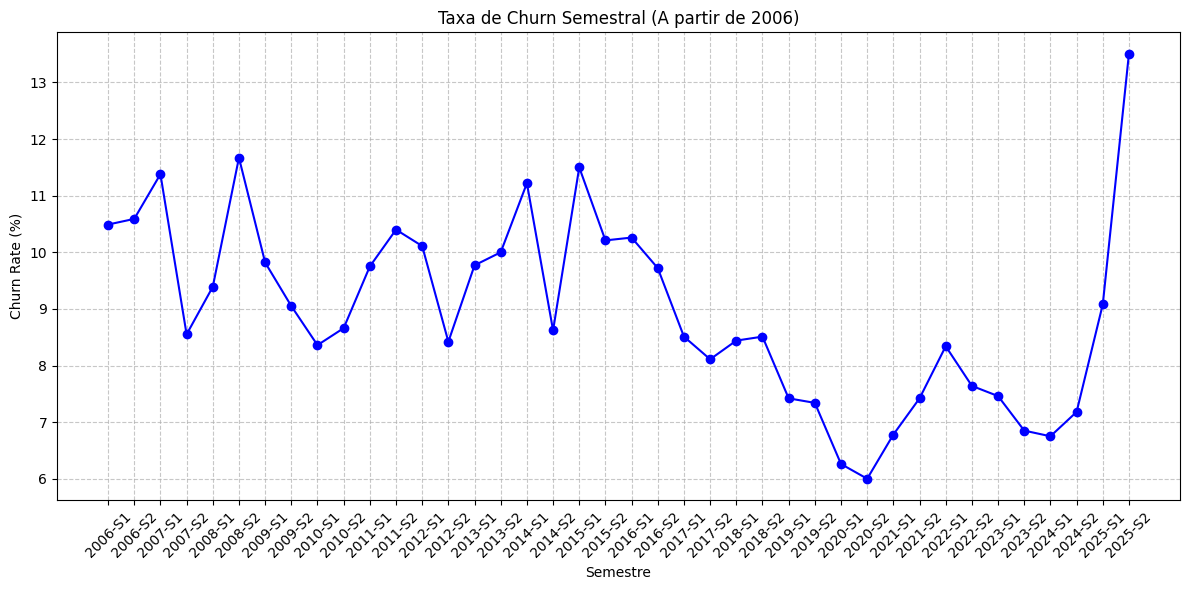

In [6]:
import os
import pandas as pd
import urllib.parse
from dotenv import load_dotenv
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt

# 1. Carregar variáveis de ambiente
load_dotenv()

# 2. Configuração das credenciais com tratamento de caracteres especiais
user     = os.getenv("PROD_POSTGRES_USERNAME")
password = urllib.parse.quote_plus(os.getenv("PROD_POSTGRES_PASSWORD"))
host     = os.getenv("PROD_POSTGRES_HOST")
database = os.getenv("PROD_POSTGRES_DATABASE")
port     = os.getenv("POST_PORT", "5432")

conn_url = f"postgresql://{user}:{password}@{host}:{port}/{database}"
engine = create_engine(conn_url)

# 3. Definição da Query SQL de Churn Semestral (Início em 2006)
sql_query = """
with base_contratos as (
    select
        distinct
        c.nr_central_sigma,
        ccc.codigo_contrato,
        ccc.data_pedido as data_inicio,
        ccc.data_rescisao,
        (
            select mcc.situacao
            from movimento_contratos_cli mcc
            where mcc.codigo_contrato = ccc.codigo_contrato
              and mcc.situacao <> 7
            order by mcc.data_conclusao desc
            limit 1
        ) as situacao_movimento
    from clientes c
    inner join cab_contratos_cli ccc on ccc.codigo_cliente = c.codigo_cliente
),

clientes_com_contrato_ativo as (
    select distinct nr_central_sigma
    from base_contratos
    where data_rescisao is null
),

churn_por_cliente as (
    select
        bc.nr_central_sigma,
        MAX(bc.data_rescisao) as data_churn
    from base_contratos bc
    where bc.data_rescisao is not null
      and bc.nr_central_sigma not in (select nr_central_sigma from clientes_com_contrato_ativo)
    group by bc.nr_central_sigma
),

data_minima as (
    -- Alterado para iniciar a análise em 2006, descartando 2004 e 2005
    select '2006-01-01'::date as inicio_historico 
),

churn_semestral as (
    select
        date_trunc('year', ch.data_churn) + (interval '6 months' * floor((extract(month from ch.data_churn) - 1) / 6)) as semestre_churn,
        COUNT(distinct ch.nr_central_sigma) as clientes_churn
    from churn_por_cliente ch
    group by 1
),

clientes_ativos_inicio_semestre as (
    select
        ss.semestre,
        COUNT(distinct bc.nr_central_sigma) as total_clientes_inicio
    from (
        select generate_series(
            (select inicio_historico from data_minima),
            CURRENT_DATE,
            '6 months'
        )::date as semestre
    ) ss
    cross join base_contratos bc
    where bc.data_inicio < ss.semestre
      and (bc.data_rescisao is null or bc.data_rescisao >= ss.semestre)
    group by ss.semestre
)

select
    concat(
        extract(year from cas.semestre), 
        case when extract(month from cas.semestre) <= 6 then '-S1' else '-S2' end
    ) as periodo_semestral,
    cas.total_clientes_inicio as clientes_inicio_semestre,
    coalesce(cs.clientes_churn, 0) as total_churn_no_semestre,
    case
        when cas.total_clientes_inicio = 0 then 0
        else ROUND((coalesce(cs.clientes_churn, 0)::numeric / cas.total_clientes_inicio::numeric) * 100, 2)
    end as churn_rate_semestral_percentual,
    case 
        when (coalesce(cs.clientes_churn, 0)::numeric / nullif(cas.total_clientes_inicio,0)::numeric) * 100 > 12 then 'CRÍTICO (>12%)'
        when (coalesce(cs.clientes_churn, 0)::numeric / nullif(cas.total_clientes_inicio,0)::numeric) * 100 > 9 then 'ALERTA'
        else 'DENTRO DA META'
    end as analise_saude
from clientes_ativos_inicio_semestre cas
left join churn_semestral cs on cas.semestre = cs.semestre_churn
where cas.total_clientes_inicio > 0
order by cas.semestre;
"""

# 4. Execução da consulta
try:
    with engine.connect() as conn:
        df_churn_semestral = pd.read_sql(text(sql_query), conn)

    print("✅ Sucesso! Os dados foram carregados em 'df_churn_semestral'.")
    print("-" * 30)
    print(df_churn_semestral.head(10)) # Exibe os primeiros 10 semestres (começando em 2006)
    print("-" * 30)

    # 5. Visualização Básica
    plt.figure(figsize=(12, 6))
    plt.plot(df_churn_semestral['periodo_semestral'], df_churn_semestral['churn_rate_semestral_percentual'], marker='o', linestyle='-', color='b')
    plt.title('Taxa de Churn Semestral (A partir de 2006)')
    plt.xlabel('Semestre')
    plt.ylabel('Churn Rate (%)')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"❌ Erro ao executar consulta: {e}")

In [7]:
df_churn_semestral

,periodo_semestral,clientes_inicio_semestre,total_churn_no_semestre,churn_rate_semestral_percentual,analise_saude
0,2006-S1,782,82,10.49,ALERTA
1,2006-S2,982,104,10.59,ALERTA
2,2007-S1,1125,128,11.38,ALERTA
3,2007-S2,1252,107,8.55,DENTRO DA META
4,2008-S1,1470,138,9.39,ALERTA
5,2008-S2,1654,193,11.67,ALERTA
6,2009-S1,1793,176,9.82,ALERTA
7,2009-S2,1878,170,9.05,ALERTA
8,2010-S1,2021,169,8.36,DENTRO DA META
9,2010-S2,2148,186,8.66,DENTRO DA META


# Iniciando Analise Descritiva da Base Semestral

### Estudo da Volatilidade e Tendência Central Semestral

In [10]:
# Média e Mediana 
media_semestral = df_churn_semestral['churn_rate_semestral_percentual'].mean()
mediana_semestral = df_churn_semestral['churn_rate_semestral_percentual'].median()
print(mediana_semestral)
print(media_semestral)

8.64
8.9885


In [11]:
# 1. Cálculo de métricas estatísticas detalhadas
media_semestral = df_churn_semestral['churn_rate_semestral_percentual'].mean()
mediana_semestral = df_churn_semestral['churn_rate_semestral_percentual'].median()
desvio_padrao = df_churn_semestral['churn_rate_semestral_percentual'].std()

print(f"Estatísticas de Churn (2006 - Presente):")
print(f"📊 Média:   {media_semestral:.2f}%")
print(f"📊 Mediana: {mediana_semestral:.2f}%")
print(f"📉 Desvio Padrão: {desvio_padrao:.2f}% (Quanto menor, mais constante é o churn)")

# 2. Identificar os 3 piores semestres (Maiores Churns)
piores_semestres = df_churn_semestral.nlargest(3, 'churn_rate_semestral_percentual')
print("\n🚨 Top 3 Semestres com maior Churn:")
print(piores_semestres[['periodo_semestral', 'churn_rate_semestral_percentual']])

# 3. Criar uma coluna de variação (comparando com o semestre anterior)
df_churn_semestral['variacao_percentual'] = df_churn_semestral['churn_rate_semestral_percentual'].diff()

print("\n📈 Últimos 5 semestres analisados:")
print(df_churn_semestral[['periodo_semestral', 'churn_rate_semestral_percentual', 'analise_saude']].tail())

Estatísticas de Churn (2006 - Presente):
📊 Média:   8.99%
📊 Mediana: 8.64%
📉 Desvio Padrão: 1.67% (Quanto menor, mais constante é o churn)

🚨 Top 3 Semestres com maior Churn:
   periodo_semestral  churn_rate_semestral_percentual
39           2025-S2                            13.51
5            2008-S2                            11.67
18           2015-S1                            11.50

📈 Últimos 5 semestres analisados:
   periodo_semestral  churn_rate_semestral_percentual   analise_saude
35           2023-S2                             6.85  DENTRO DA META
36           2024-S1                             6.75  DENTRO DA META
37           2024-S2                             7.18  DENTRO DA META
38           2025-S1                             9.08          ALERTA
39           2025-S2                            13.51  CRÍTICO (>12%)
